In [53]:
import pickle
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
import data_dictionary
import matplotlib.pyplot as plt

# Data Import

In [2]:
df = pd.read_csv("bankrupt_data.csv")
print(df.shape)
df.head()

(9792, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.159290,0.46240,0.07773,1.1683,-44.853,0.467020,0.189480,0.82895,1.1223,0.38330,...,0.108990,0.41557,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.0560,0
1,-0.127430,0.46243,0.26917,1.7517,7.597,0.000925,-0.127430,1.16250,1.2944,0.53757,...,-0.089372,-0.23704,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.4725,0
2,0.070488,0.23570,0.52781,3.2393,125.680,0.163670,0.086895,2.87180,1.0574,0.67689,...,0.054286,0.10413,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.7818,0
3,0.136760,0.40538,0.31543,1.8705,19.115,0.504970,0.136760,1.45390,1.1144,0.58938,...,0.102630,0.23203,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.6484,0
4,-0.110080,0.69793,0.18878,1.2713,-15.344,0.000000,-0.110080,0.43282,1.7350,0.30207,...,0.439880,-0.36440,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.0360,0


# Split data

In [3]:
# splitting data into feature matrix X and target vector y
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (9792, 64)
y shape: (9792,)


In [4]:
# divide into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (7833, 64)
y_train shape: (7833,)
X_test shape:  (1959, 64)
y_test shape:  (1959,)


## Resample minority class (oversampling)

In [5]:
# Oversampling feature matrix and target vector
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(f"X_train_over shape: {X_train_over.shape}")
X_train_over.head()

X_train_over shape: (14842, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.069548,0.69574,0.055553,1.0897,-27.2160,-0.264400,0.069113,0.36634,1.0355,0.25488,...,580.85,0.034314,0.272870,0.96569,0.30020,10.9890,6.4865,85.355,4.2762,8.1421
1,-0.084151,0.62034,0.114540,1.2505,-5.9921,0.000000,-0.084151,0.61202,1.6597,0.37966,...,557.14,-0.121260,-0.221650,1.04600,0.00000,11.5100,7.3495,100.560,3.6295,3.8759
2,0.081425,0.10163,0.424230,5.1741,124.5500,0.297150,0.101460,8.52550,1.1220,0.86647,...,18200.00,0.108710,0.093974,0.89129,0.00000,5.5087,3.9838,41.429,8.8102,1.8885
3,0.011690,0.80729,-0.216890,0.6474,-124.9500,-0.037361,0.011781,0.23871,1.0410,0.19271,...,-3420.70,0.039353,0.060664,0.96065,0.99729,17.1860,2.5425,259.880,1.4045,1.4356
4,0.000917,0.33013,0.591420,2.8261,-30.7370,0.000000,0.000917,2.02910,1.4833,0.66987,...,3355.10,0.270390,0.001369,0.73336,0.00000,2.2321,6.9965,79.698,4.5798,17.5120


# Buiding model

## Baseline

In [7]:
# Let us first define our baseline as the Accuracy score
# considering that we classify every firm as not bankrupt
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9474


## Iterating

In [10]:
# creating classifier pipeline
clf = make_pipeline(
    SimpleImputer(),
    GradientBoostingClassifier()
)

In [8]:
# defining params for the classifier gridsearch
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [11]:
# assigning gridsearch object to model variable
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

In [12]:
# training the gridsearch models 
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [14]:
# visualizing gridsearch models training results
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,21.727220,0.270894,0.018998,0.001092,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.915460,0.914449,0.904650,0.914420,0.914420,0.912680,0.004035,1
17,18.285894,3.326367,0.012398,0.002796,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.917481,0.902324,0.900270,0.904987,0.907682,0.906549,0.006008,2
14,18.116743,0.246235,0.018203,0.001468,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.903334,0.906029,0.902291,0.906334,0.900943,0.903786,0.002100,3
15,18.339265,0.154117,0.020667,0.002741,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.901987,0.891883,0.893868,0.897237,0.899596,0.896914,0.003678,4
12,14.405308,0.180659,0.018243,0.001196,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.894240,0.895925,0.892520,0.895553,0.889825,0.893613,0.002238,5
13,14.576188,0.106182,0.020998,0.003100,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.889525,0.886494,0.885445,0.890836,0.886456,0.887751,0.002061,6
10,16.599296,0.171524,0.020999,0.003285,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.867295,0.878747,0.871294,0.868598,0.863544,0.869896,0.005081,7
11,16.699896,0.135926,0.018007,0.000885,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.866285,0.864938,0.859501,0.870957,0.864218,0.865180,0.003683,8
8,14.455332,0.265054,0.018008,0.001798,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.858538,0.874368,0.865566,0.864892,0.858154,0.864304,0.005904,9
9,14.214571,0.061098,0.028400,0.022322,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.860896,0.860896,0.848383,0.863881,0.858154,0.858442,0.005346,10


In [15]:
# verifying best params from gridsearch models training
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

# Evaluating the model

In [16]:
# calculating model accuracy for training and test sets
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9138
Test Accuracy: 0.8964


In [17]:
# double checking True labels count
y_test.value_counts()

bankrupt
0    1856
1     103
Name: count, dtype: int64

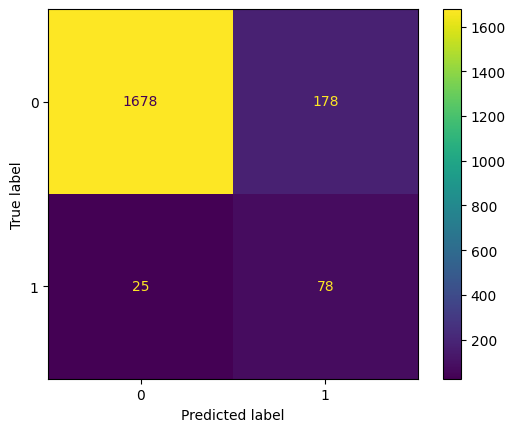

In [18]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Recall and Precision metrics for our minority class (bankrupt companies):

Let's remember how they are calculated:  
Recall = True Positives / (True Positives + False Negatives)  
Precision measures the proportion of positive predictions made by the model that are actually positive. It is calculated as:  
Precision = True Positives / (True Positives + False Positives)

In [19]:
print("Recall    = ", f"{(78/(78+25)*100):.2f}%")
print("Precision = ", f"{(78/(78+178)*100):.2f}%")

Recall    =  75.73%
Precision =  30.47%


In [20]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1856
           1       0.30      0.76      0.43       103

    accuracy                           0.90      1959
   macro avg       0.65      0.83      0.69      1959
weighted avg       0.95      0.90      0.92      1959



# Communicating the results

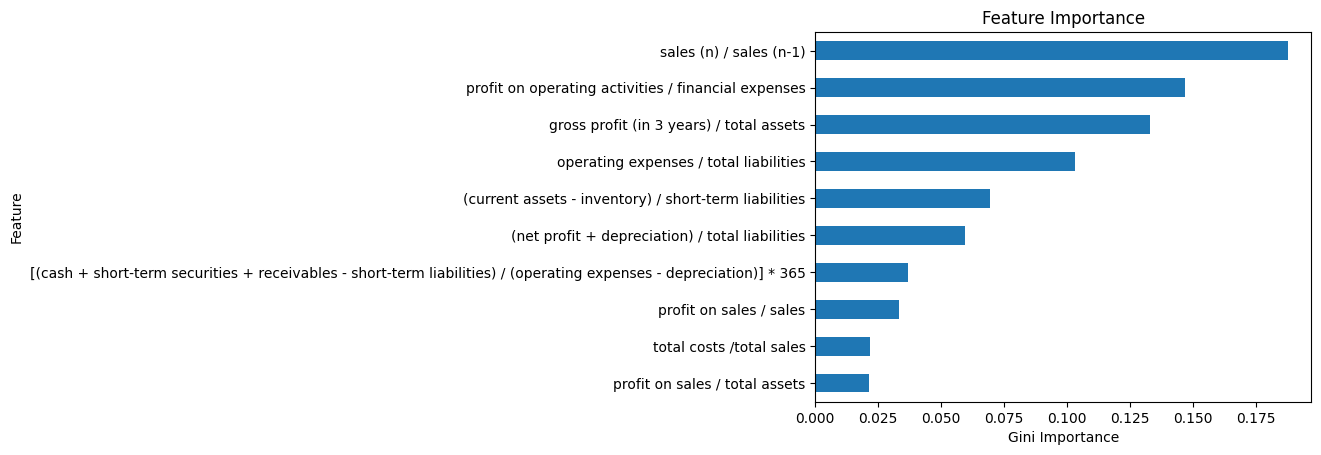

In [31]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["gradientboostingclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values().rename(data_dictionary.feat_desc)
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [32]:
# Save model
with open("gradboost", "wb") as file:
    pickle.dump(model, file)

In [36]:
# loading our model to check if it was correctly saved
with open("gradboost", "rb") as f:
    loaded_model = pickle.load(f)

print(loaded_model)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)


In [37]:
# testing loaded model
loaded_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [39]:
# double checking number of predicted bankrupt companies (should be 256, 78 TP + 178 FP)
loaded_model.predict(X_test).sum()

256

# Comparison between trained models

## Decision tree vs. Random Forest vs. Gradient Boosting

### Precision vs. Recall curve

In [40]:
# loading our decision tree model
with open("dtree_model", "rb") as f:
    dtree_model = pickle.load(f)

In [41]:
# loading our random forest model
with open("randfor", "rb") as f:
    randfor_model = pickle.load(f)

In [42]:
# loading our gradient boosting model
with open("gradboost", "rb") as f:
    gradboost_model = pickle.load(f)

In [44]:
# Calculate precision and recall values for different threshold levels (considering minority class)
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dtree_model.predict_proba(X_test)[:, -1])
rf_precision, rf_recall, _ = precision_recall_curve(y_test, randfor_model.predict_proba(X_test)[:, -1])
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gradboost_model.predict_proba(X_test)[:, -1])

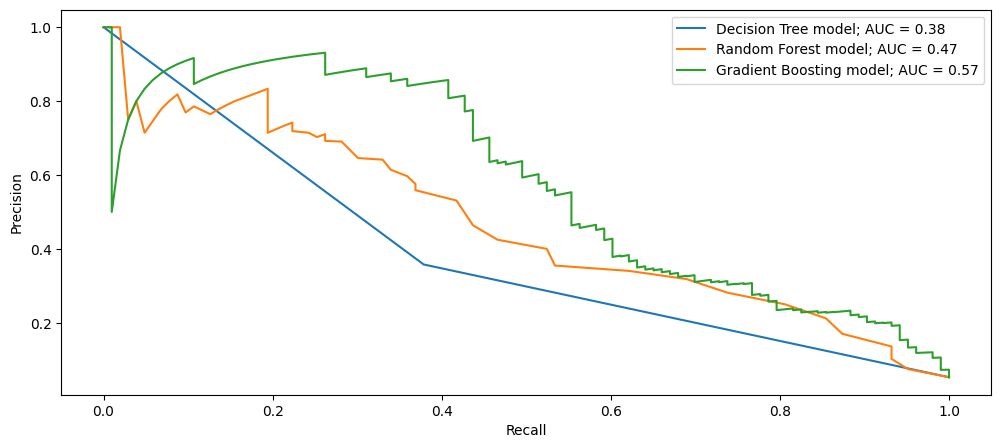

In [59]:
# Plot the precision-recall curves  and calculating the Area Under the Curve (AUC) for the three classifiers
plt.figure(figsize=(12, 5))
plt.plot(dt_recall, dt_precision, label=f'Decision Tree model; AUC = {auc(dt_recall, dt_precision):.2f}')
plt.plot(rf_recall, rf_precision, label=f'Random Forest model; AUC = {auc(rf_recall, rf_precision):.2f}')
plt.plot(gb_recall, gb_precision, label=f'Gradient Boosting model; AUC = {auc(gb_recall, gb_precision):.2f}')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# Show the plot
plt.show()